### Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import json


### Dataset Loading & Preprocessing

In [3]:
def get_mnist_dataloaders(batch_size=128, root="./data"):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    train_ds = datasets.MNIST(root=root, train=True, transform=transform, download=True)
    test_ds = datasets.MNIST(root=root, train=False, transform=transform, download=True)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


### VAE Model

In [4]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, 4, 2, 1)
        self.enc_conv2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.enc_conv3 = nn.Conv2d(64, 128, 3, 1, 1)

        self.flat_dim = 128 * 7 * 7
        self.fc_mu = nn.Linear(self.flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(latent_dim, self.flat_dim)
        self.dec_deconv1 = nn.ConvTranspose2d(128, 64, 3, 1, 1)
        self.dec_deconv2 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.dec_deconv3 = nn.ConvTranspose2d(32, 1, 4, 2, 1)

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = x.view(-1, self.flat_dim)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.dec_fc(z)
        x = x.view(-1, 128, 7, 7)
        x = F.relu(self.dec_deconv1(x))
        x = F.relu(self.dec_deconv2(x))
        x = torch.sigmoid(self.dec_deconv3(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


### Loss Function

In [5]:
def vae_loss(recon_x, x, mu, logvar):
    recon = F.mse_loss(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl, recon, kl

# Train the model

def train_vae(model, train_loader, test_loader, epochs=50, lr=1e-3, device="cuda"):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_loss": []
    }

    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()

            recon, mu, logvar = model(x)
            loss, r, k = vae_loss(recon, x, mu, logvar)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                recon, mu, logvar = model(x)
                loss, _, _ = vae_loss(recon, x, mu, logvar)
                val_loss += loss.item()

        n_train = len(train_loader.dataset)
        n_test = len(test_loader.dataset)

        history["train_loss"].append(train_loss / n_train)
        history["val_loss"].append(val_loss / n_test)

        print(f"Epoch {epoch+1}/{epochs} | train {train_loss/n_train:.4f} | val {val_loss/n_test:.4f}")

    return history


### Reconstruction Visualization Function

In [6]:
def show_reconstruction(model, test_loader, device="cuda", n=10):
    model.eval()
    model.to(device)

    imgs, _ = next(iter(test_loader))
    imgs = imgs[:n].to(device)

    with torch.no_grad():
        recon, _, _ = model(imgs)

    imgs = imgs.cpu()
    recon = recon.cpu()

    fig, ax = plt.subplots(2, n, figsize=(n*1.4, 3))
    for i in range(n):
        ax[0, i].imshow(imgs[i].squeeze(), cmap='gray')
        ax[0, i].axis("off")

        ax[1, i].imshow(recon[i].squeeze(), cmap='gray')
        ax[1, i].axis("off")

    plt.show()


### Latent Space t-SNE Visualization Function

In [20]:
def show_tsne(model, test_loader, n_samples=2000, device="cuda"):
    model.eval()
    Z, Y = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            mu, logvar = model.encode(x)
            z = mu.cpu().numpy()
            Z.append(z)
            Y.append(y.numpy())
            if len(np.concatenate(Z, 0)) >= n_samples:
                break

    Z = np.concatenate(Z, axis=0)[:n_samples]
    Y = np.concatenate(Y, axis=0)[:n_samples]

    # FIX: use max_iter
    tsne = TSNE(n_components=2, perplexity=30, max_iter=800)
    Z2 = tsne.fit_transform(Z)

    plt.figure(figsize=(7,7))
    scatter = plt.scatter(Z2[:, 0], Z2[:, 1], c=Y, s=5)
    plt.colorbar(scatter)
    plt.title("t-SNE Latent Space Visualization")
    plt.show()


### Generation Function (random z → images)

In [8]:
def generate_samples(model, latent_dim, n=25, device="cuda"):
    model.eval()
    model.to(device)

    z = torch.randn(n, latent_dim).to(device)
    with torch.no_grad():
        imgs = model.decode(z).cpu()

    r = int(np.sqrt(n))

    fig, ax = plt.subplots(r, r, figsize=(r*1.4, r*1.4))
    idx = 0
    for i in range(r):
        for j in range(r):
            ax[i, j].imshow(imgs[idx].squeeze(), cmap='gray')
            ax[i, j].axis("off")
            idx += 1

    plt.show()


### Interpolation Function

In [9]:
def interpolate(model, latent_dim, steps=10, device="cuda"):
    model.eval()
    model.to(device)

    z1 = torch.randn(1, latent_dim).to(device)
    z2 = torch.randn(1, latent_dim).to(device)

    alphas = torch.linspace(0, 1, steps).to(device).unsqueeze(-1)
    zs = z1 * (1 - alphas) + z2 * alphas

    with torch.no_grad():
        imgs = model.decode(zs).cpu()

    fig, ax = plt.subplots(1, steps, figsize=(steps*1.2, 2))
    for i in range(steps):
        ax[i].imshow(imgs[i].squeeze(), cmap='gray')
        ax[i].axis("off")
    plt.show()


### Train Model-128

In [10]:
train_loader, test_loader = get_mnist_dataloaders(batch_size=128)

model128 = ConvVAE(latent_dim=128)
hist128 = train_vae(model128, train_loader, test_loader, epochs=50, lr=1e-3)


Epoch 1/50 | train 48.1460 | val 35.5434
Epoch 2/50 | train 33.5775 | val 31.9405
Epoch 3/50 | train 31.5523 | val 30.7131
Epoch 4/50 | train 30.5890 | val 29.9704
Epoch 5/50 | train 29.9479 | val 29.4224
Epoch 6/50 | train 29.6124 | val 29.2475
Epoch 7/50 | train 29.3094 | val 29.1118
Epoch 8/50 | train 29.0825 | val 28.7606
Epoch 9/50 | train 28.9423 | val 28.6417
Epoch 10/50 | train 28.7850 | val 28.4891
Epoch 11/50 | train 28.6377 | val 28.4471
Epoch 12/50 | train 28.5301 | val 28.3599
Epoch 13/50 | train 28.3998 | val 28.3694
Epoch 14/50 | train 28.3463 | val 28.1517
Epoch 15/50 | train 28.2721 | val 28.1855
Epoch 16/50 | train 28.1897 | val 28.0765
Epoch 17/50 | train 28.1211 | val 27.9422
Epoch 18/50 | train 28.0398 | val 27.9121
Epoch 19/50 | train 27.9930 | val 27.8764
Epoch 20/50 | train 27.9380 | val 28.0432
Epoch 21/50 | train 27.9145 | val 27.8284
Epoch 22/50 | train 27.8418 | val 27.6890
Epoch 23/50 | train 27.7882 | val 27.6692
Epoch 24/50 | train 27.7589 | val 27.6937
E

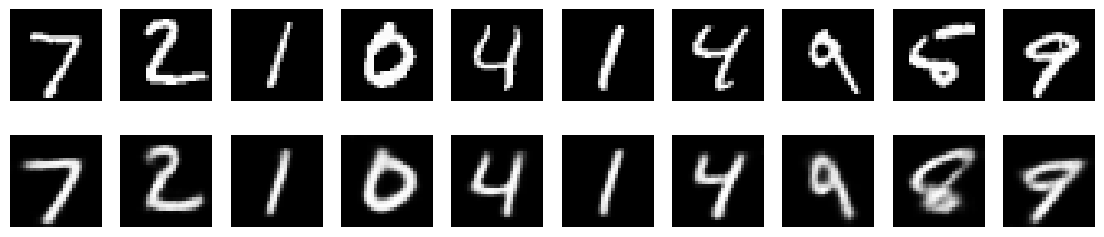

In [11]:
show_reconstruction(model128, test_loader)

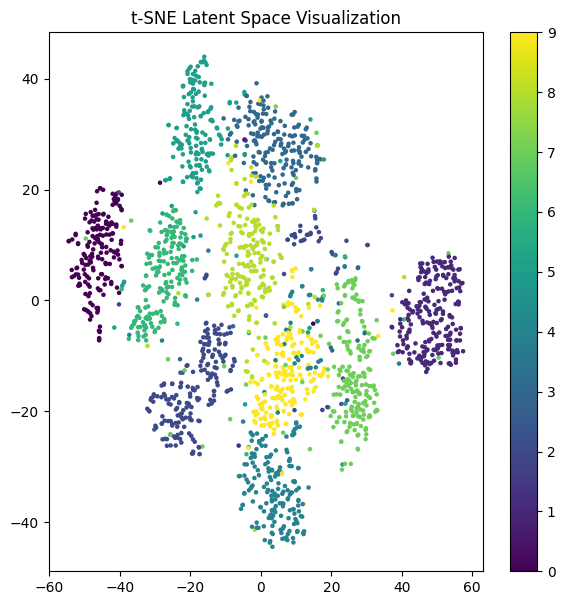

In [22]:
show_tsne(model128, test_loader)

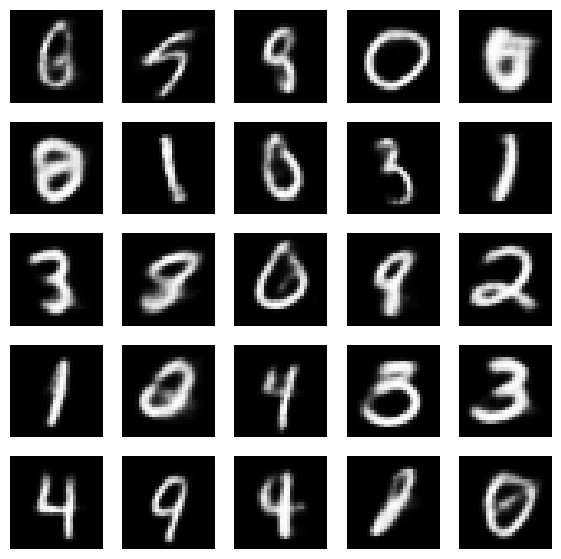

In [13]:
generate_samples(model128, 128)

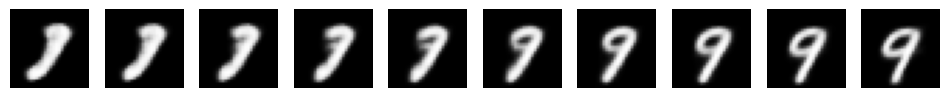

In [14]:
interpolate(model128, 128)

### Train Model-256

In [15]:
model256 = ConvVAE(latent_dim=256)
hist256 = train_vae(model256, train_loader, test_loader, epochs=50, lr=1e-3)


Epoch 1/50 | train 48.3579 | val 40.0176
Epoch 2/50 | train 37.7305 | val 35.8473
Epoch 3/50 | train 34.1191 | val 32.5243
Epoch 4/50 | train 32.1681 | val 31.4378
Epoch 5/50 | train 31.3083 | val 30.7560
Epoch 6/50 | train 30.6938 | val 30.3116
Epoch 7/50 | train 30.3277 | val 29.9174
Epoch 8/50 | train 30.0251 | val 29.6448
Epoch 9/50 | train 29.7286 | val 29.3374
Epoch 10/50 | train 29.5393 | val 29.2901
Epoch 11/50 | train 29.3649 | val 29.0564
Epoch 12/50 | train 29.2008 | val 29.0337
Epoch 13/50 | train 29.0419 | val 28.7216
Epoch 14/50 | train 28.9170 | val 28.6560
Epoch 15/50 | train 28.8557 | val 28.7796
Epoch 16/50 | train 28.7686 | val 28.6695
Epoch 17/50 | train 28.6410 | val 28.4126
Epoch 18/50 | train 28.5473 | val 28.3201
Epoch 19/50 | train 28.4880 | val 28.2688
Epoch 20/50 | train 28.4349 | val 28.4435
Epoch 21/50 | train 28.3654 | val 28.2723
Epoch 22/50 | train 28.3043 | val 28.2206
Epoch 23/50 | train 28.2506 | val 28.1173
Epoch 24/50 | train 28.1956 | val 28.1538
E

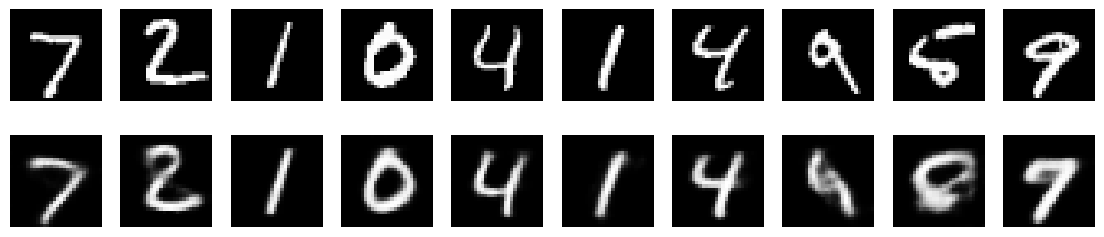

In [16]:
show_reconstruction(model256, test_loader)

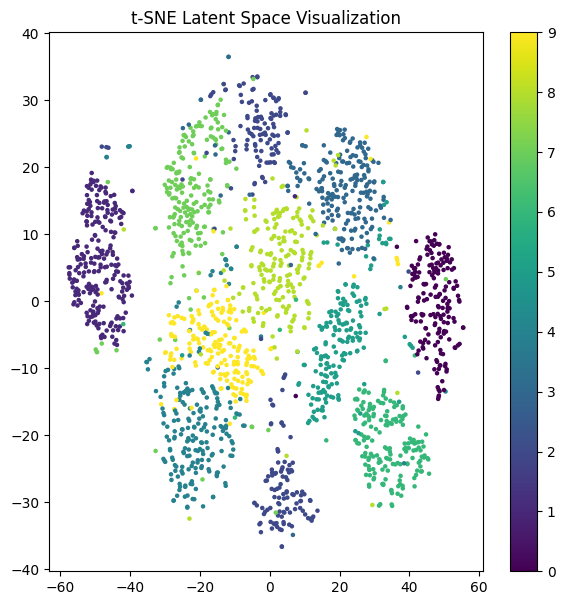

In [21]:
show_tsne(model256, test_loader)

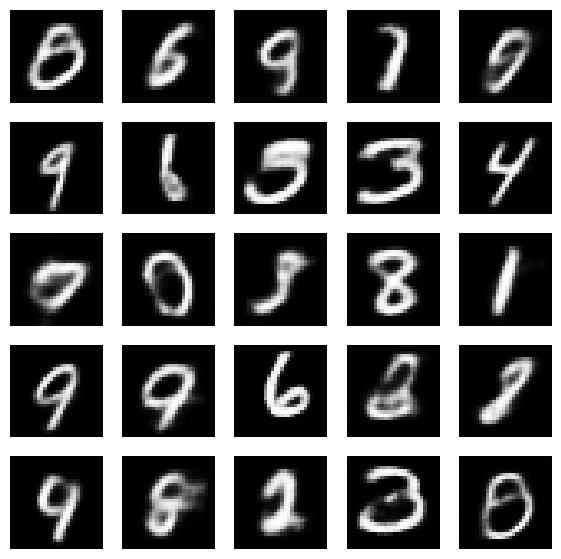

In [18]:
generate_samples(model256, 256)


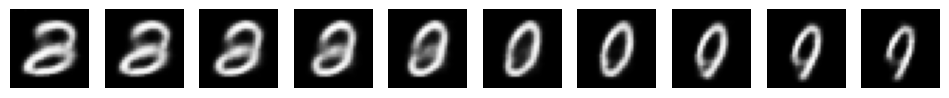

In [19]:
interpolate(model256, 256)

### Discussion